In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import copy
import gdown
import threading
import importlib
import sys
from tqdm.notebook import tqdm
import ctypes

# Competição de AI's para o jogo de Othello

A atividade final do curso de aprendizado por reforço é uma compedição de AI's para o jogo de Othello. Reveja as regras do jogo
[neste notebook](https://colab.research.google.com/drive/14vsUbeO1d8K-PSxCagtRH7DYm68S-AB0?usp=sharing).

Novamente, a classe ```Othello``` implementa as regras do jogo.

In [ ]:
class Othello():

  direcoes_captura =\
   [(-1, -1), (-1, 0), (-1, +1), (0, -1), (0, +1), (+1, -1), (+1, 0), (+1, +1)]

  def __init__(self, outro = None, estado = None):
    if estado:
      self._carrega_estado(estado)
    elif outro:  # Construtor de cópia
      self._cols = outro._cols
      self._lins = outro._lins
      self._jogador_atual = outro._jogador_atual
      self._tabuleiro = copy.deepcopy(outro._tabuleiro)
      self._terminou = outro._terminou
      self._placar = list(outro._placar)
      # Normalmente essa informação vai ser descartada, então não é copiada
      self._capturas = None
      self._jogadas_legais = None
    else: # Novo jogo
      self._cols = 8
      self._lins = 8
      self._reset()

  def _reset(self):
    self._jogador_atual = 1
    self._tabuleiro = [\
      [ 0, 0, 0, 0, 0, 0, 0, 0],\
      [ 0, 0, 0, 0, 0, 0, 0, 0],\
      [ 0, 0, 0, 0, 0, 0, 0, 0],\
      [ 0, 0, 0,-1, 1, 0, 0, 0],\
      [ 0, 0, 0, 1,-1, 0, 0, 0],\
      [ 0, 0, 0, 0, 0, 0, 0, 0],\
      [ 0, 0, 0, 0, 0, 0, 0, 0],\
      [ 0, 0, 0, 0, 0, 0, 0, 0]\
    ]
    self._terminou = False
    self._placar = [2,2]
    self._capturas = None
    self._jogadas_legais = None

  def dim(self):
    return (self._cols, self._lins)

  def jogador_atual(self):
    self._checa_estado_atualizado()
    return self._jogador_atual

  # Retorna o conteúdo do tabuleiro em uma posicao
  def posicao(self, posicao):
    return self._tabuleiro[posicao[0]][posicao[1]]

  # Retorna uma cópia do tabuleiro
  def tabuleiro(self):
    return np.array(self._tabuleiro, dtype=np.int8)

  def placar(self, jogador):
    return self._placar[(1+jogador)//2]

  # O estado só é completamente computado caso seja necessário
  # pois algumas jogadas podem ser descartadas
  def _checa_estado_atualizado(self):
    if self._jogadas_legais is None:
      self._atualiza_capturas_e_jogadas_legais()
      # Verifica se jogador atual tem jogadas disponíveis
      if len(self._jogadas_legais)==0:
        # Troca de jogador
        self._jogador_atual = -self._jogador_atual
        self._atualiza_capturas_e_jogadas_legais()
        # Jogo terminou?
        if len(self._jogadas_legais)==0:
          self._terminou = True

  # Verdadeiro se o jogo terminou, falso caso contrário
  def terminou(self):
    self._checa_estado_atualizado()
    return self._terminou

  # Verifica se uma determinada posicao é valida
  def posicao_valida(self, posicao):
    return posicao[0]>=0 and posicao[0]<self._lins and posicao[1]>=0 and posicao[1]<self._cols

  # Retorna a lista de capturas em uma determinada direção
  def _lista_de_capturas(self, posicao, direcao, jogador):
    posicoes = []
    lin = posicao[0] + direcao[0]
    col = posicao[1] + direcao[1]
    while self.posicao_valida((lin, col)) and self.posicao((lin, col)) == -jogador:
      posicoes.append((lin, col))
      lin += direcao[0]
      col += direcao[1]
    return posicoes if self.posicao_valida((lin, col)) and self.posicao((lin, col)) == jogador else []

  # Atualiza a lista de jogadas legais
  def _atualiza_capturas_e_jogadas_legais(self):
    self._jogadas_legais = set()
    self._capturas = []
    for i in range(self._lins):
      self._capturas.append([])
      for j in range(self._cols):
        cap_possivel = False
        if self._tabuleiro[i][j]==0:
          self._capturas[-1].append([])
          for d in Othello.direcoes_captura:
            self._capturas[-1][-1].append(self._lista_de_capturas((i, j), d, self._jogador_atual)            )
            cap_possivel = cap_possivel or len(self._capturas[-1][-1][-1])>0
        else:
          self._capturas[-1].append([[]]*len(Othello.direcoes_captura))
        if cap_possivel:
          self._jogadas_legais.add((i, j))

  # Verifica se uma jogada é legal
  def jogada_legal(self, jogada):
    self._checa_estado_atualizado()
    return jogada in self._jogadas_legais

  # Retorna o conjunto de jogadas legais
  def jogadas_legais(self):
    self._checa_estado_atualizado()
    return list(self._jogadas_legais)

  # Processa a captura de peças após uma jogada com base em listas de capturas
  def _processa_captura_pecas(self, listas_de_capturas):
    for lista_capturas in listas_de_capturas:
      for pi, pj in lista_capturas:
          self._tabuleiro[pi][pj] = self._jogador_atual
          self._placar[(1+self._jogador_atual)//2] += 1
          self._placar[(1-self._jogador_atual)//2] -= 1

  # Aplica uma jogada. Precisa de uma lista de capturas a ser executada
  def _aplica_jogada(self, jogada, listas_de_capturas):
    self._tabuleiro[jogada[0]][jogada[1]] = self._jogador_atual
    self._placar[(1+self._jogador_atual)//2] += 1
    self._processa_captura_pecas(listas_de_capturas)
    self._jogador_atual = -self._jogador_atual
    self._atualiza_capturas_e_jogadas_legais()
    # Verifica se jogador atual tem jogadas disponíveis
    if len(self._jogadas_legais)==0:
        # Troca de jogador
        self._jogador_atual = -self._jogador_atual
        self._atualiza_capturas_e_jogadas_legais()
        # Jogo terminou?
        if len(self._jogadas_legais)==0:
          self._terminou = True

  # Aplica jogada
  # Retorna um *novo jogo*
  def joga(self, jogada):
    self._checa_estado_atualizado()
    if self._terminou:
      raise RuntimeError("Jogo encerrado")
    if not self.jogada_legal(jogada):
      raise RuntimeError("Jogada Ilegal")
    # Clona jogo atual
    novo_jogo = Othello(self)
    novo_jogo._aplica_jogada(jogada, self._capturas[jogada[0]][jogada[1]])
    # O jogo é retornado em um estado semi-computado
    return novo_jogo

Os métodos relevantes são:

> ```__init__(self, outro = None)```: Constrói um novo jogo. Caso o método receba outro jogo no parâmetro ```outro```, é criada uma cópia deste jogo.

> ```jogador_atual(self)```: Retorna o índice do jogador atual. Os índices possíveis são -1 e 1. O jogador inicial é o jogador de índice 1. Este valor deve ser desconsiderado caso o jogo tenha acabado. Vide método ```terminou()``` adiante.

> ```posicao(self, posicao)```: Retorna o conteúdo do tabuleiro em uma determinada posição. Posição é uma tupla com os índices da linha e coluna do tabuleiro (baseados em zero). O valor retornado é o índice do jogador que possui a ficha na posição indicada ou zero se a posição está vazia.

> ```dim(self)```: Retona as dimensões do tabuleiro. Esta implementação retorna sempre $8 \times 8$.

> ```tabuleiro(self)```: Retorna um *array* numpy com o conteúdo do tabuleiro.

> ```placar(self, jogador)```: Retorna o placar do jogador passado no parâmetro ```jogador``` (este valor deve ser -1 ou 1).

> ```terminou(self)```: Retorna ```True``` caso o jogo tenha acabado, ```False``` caso contrário. Nota: Caso o jogo tenha terminado, o valor retornado pelo método ```jogador_atual()``` deve ser desconsiderado.

> ```jogada_legal(self, jogada)```: Retorna ```True``` caso o jogador atual possa jogar uma ficha na posição indicada por ```jogada```, ```False``` caso contrário. Jogadas são tuplas com linha e coluna.

> ```jogadas_legais(self)```: Retorna uma sequência com a lista de todas as jogadas legais para o jogador atual.

> ```joga(self, jogada)```: Retorna o resultado da jogada descrita no parâmetro ```jogada```. Este parâmetro é uma tupla com a linha e coluna onde deve ser colocada a ficha. Note que este método *não* modifica o estado do objeto, mas retorna um *novo* jogo com o resultado da jogada. Assim, se por exemplo a variável ```jogo``` contém o estado *atual* do jogo e a variável ```jogada``` contém a próxima jogada a ser feita, a variável jogo deve ser atualizada da seguinte maneira:
```
jogo = jogo.joga(jogada)
```




Experimente as regras do jogo com uma partida iterativa:

In [ ]:
def partida_interativa(jogo):
  rows, cols = jogo.dim()

  buttons = [widgets.Button(value = i, description=' ',disabled=False,buttom_style='',layout={'width': '35px', 'height': '35px'}) for i in range(cols*rows)]
  estado = widgets.HBox([widgets.Label(""), widgets.HTML(" ")])
  placar = widgets.VBox([widgets.Label("Placar:"),widgets.HTML(" "), widgets.HTML(" ")])

  def atualiza_jogo(jog):
    for ii in range(cols*rows):
      i = ii//rows
      j = ii % rows
      e = jog.posicao((i, j))
      if e==0:
        buttons[ii].disabled = not jog.jogada_legal((i,j))
      elif e==-1:
        buttons[ii].disabled = True
        buttons[ii].style.button_color = 'white'
      else:
        buttons[ii].disabled = True
        buttons[ii].style.button_color = 'black'
      placar.children[1].value = "<div style='text-align: center;background-color:White; color:Black'>{}</div>".format(jog.placar(-1))
      placar.children[2].value = "<div style='text-align: center;background-color:Black; color:White'>{}</div>".format(jog.placar(1))
    if jog.terminou():
      estado.children[0].value="Jogo terminou"
      estado.children[1].value=""
    else:
      estado.children[0].value="Proximo Jogador: "
      estado.children[1].value="<div style='background-color:Black'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</div>" if jog.jogador_atual()>0 else "<div style='background-color:White'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</div>"

  def registra_jogada(jogada):
    nonlocal jogo
    jogo = jogo.joga(jogada)
    atualiza_jogo(jogo)

  for i, b in enumerate(buttons):
    b.on_click((lambda x: lambda b: registra_jogada(x))((i//rows, i%cols)))
  board = widgets.GridBox(buttons, layout=widgets.Layout(grid_template_columns="repeat("+str(cols)+", 40px)"))

  display(widgets.VBox([widgets.HBox([board, placar]),estado]))
  atualiza_jogo(jogo)

In [ ]:
partida_interativa(Othello())

Você deve implementar uma inteligência artifical para o jogo.
Sua inteligência artifical deve ser da forma de um objeto que implementa uma interface específica.

Como modelo, considere a classe ```JogadorAleatorio```:

In [ ]:
class JogadorAleatorio():
  def __init__(self):
    pass

  def nova_partida(self, jogo, jogador, id_oponente = None):
    pass

  def escolhe_jogada(self, jogo):
    jogadas_possiveis = jogo.jogadas_legais()
    return jogadas_possiveis[np.random.choice(len(jogadas_possiveis))]

  def informa_propria_jogada(self, tabuleiro_antes, jogada, tabuleiro_depois):
    pass

  def informa_jogada_oponente(self, tabuleiro_antes, jogada, tabuleiro_depois):
    pass

  def informa_fim(self, jogo_final):
    pass

  @classmethod
  def cria_jogador(cls):
    return JogadorAleatorio()

Esta é uma classe que faz jogadas puramente aleatórias.

Ela implementa todos os métodos que sua AI deve implementar.

Eles são:


> ```nova_partida(self, jogo, jogador, id_oponente = None)```: Notifica o jogador do início de uma nova partida. O parâmetro ```jogo``` contém o estado inicial e o parâmetro ```jogador``` o número (-1 ou 1) do jogador que este objeto irá representar. O parâmetro opcional ```id_oponente``` é um identificador único do oponente. Cada AI da competição receberá um identificador único.
Você pode usar este identificador para adotar estratégias especializadas contra oponentes específicos.


> ```escolhe_jogada(self, jogo)```: Retorna a próxima jogada do jogador. O parâmetro ```jogo``` é um objeto da classe ```Othello``` com o estado da partida.

> ```informa_propria_jogada(self, tabuleiro_antes, jogada, tabuleiro_depois)```: Notifica o jogador do resultado de uma jogada feita pelo jogador que ele representa. O parâmetro ```tabuleiro_antes``` contém um objeto da classe ```Othello``` com o estado do jogo *antes* da jogada, o parâmetro ```jogada``` contém a jogada feita e o parâmetro ```tabuleiro_depois``` contém o estado do tabuleiro *depois* da jogada.

> ```informa_jogada_oponente(self, tabuleiro_antes, jogada, tabuleiro_depois)```: Notifica o jogador do resultado de uma jogada feita pelo jogador oponente. O parâmetro ```tabuleiro_antes``` contém um objeto da classe ```Othello``` com o estado do jogo *antes* da jogada, o parâmetro ```jogada``` contém a jogada feita e o parâmetro ```tabuleiro_depois``` contém o estado do tabuleiro *depois* da jogada.

> ```informa_fim(self, jogo_final)```: Notifica o jogador do término do jogo.
O parâmetro ```jogo_final``` contém o estado do jogo ao final da partida.


## Do formato das equipes

As equipes serão compostas de no máximo 2 alunos.
Equipes individuais são aceitas.


## Do formato da competição

A competição será feita em duas fases, uma de grupos e uma eliminatória.

Na primeira fase.
Estas competições ocorrem em 2 turnos, com uma semana de espaço entre cada turno.
Em ambos os turnos, todas as equipes jogam contra todas.
A cada vitória um grupo ganha 2 pontos, a cada empate ganha 1 ponto.
As partidas do primeiro turno serão todas publicadas ao seu término.
É permitido às equipes ajustarem seus jogadores entre os turnos.

Na segunda fase, eliminatória, é dividida em seminifinais, disputa de terceiro lugar e final.
Nas seminfinais o primeiro colocado geral joga contra o quarto colocado, e o segundo colocado contra o terceiro.
Os dois derrotados jogam a disputa de terceiro lugar.
Os dois vencedores jogam a partida final.

### Do formato das partidas

Cada partida consiste em 400 (duzentas) sub-partidas de Othello entre dois jogadores.
O jogador com a maior quantidade de vitórias é considerado vencedor.
Caso ambos tenham a mesma quantidade de vitórias, o resultado é considerado um empate.

Cada jogador joga 200 partidas como primeiro jogador e 200 partidas como segundo. A ordem das posições é aleatória.


## Do formato das entregas

Você deve submeter sua AI no formato de um *pacote* python.
O pacote consiste em um diretório com diversos arquivos.
O seu pacote deve conter um módulo chamado ```jogador``` (em um arquivo ```jogador.py```).
Este módulo deve exportar uma função chamada ```cria_jogador()```.

Esta função deve criar um objeto jogador que exponha a interface descrita na classe ```JogadorAleatorio``` acima.

Seu pacote deve ser compartilhado como uma pasta compartilhada do google drive.
A pasta deve ser compartilhada de forma a ser acessível a todo usuário com o link.

Um exemplo de pasta está aqui:

[https://drive.google.com/drive/folders/16oWy-6vuDp-g8SYNzY_iycGqJ4m_vGhG?usp=sharing](https://drive.google.com/drive/folders/16oWy-6vuDp-g8SYNzY_iycGqJ4m_vGhG?usp=sharing)


In [ ]:
gdown.download_folder("https://drive.google.com/drive/folders/16oWy-6vuDp-g8SYNzY_iycGqJ4m_vGhG?usp=sharing", output="jogadores_othello/jogador_exemplo_01")

Agora podemos carregar o módulo:

In [ ]:
def carrega_modulo(modulo, pacote, caminho):
  nome_completo = f"{pacote}.{modulo}"
  # Verifica se modulo ja esta carregado
  if nome_completo not in sys.modules:
    # Verifica se pacote esta carregado
    if pacote not in sys.modules:
      # Verifica se existe __init__.py
      caminho_pacote = f"{caminho}/{pacote}/__init__.py"
      spec_pacote =  importlib.util.spec_from_file_location(pacote, caminho_pacote)
      if spec_pacote:
        modulo_pacote = importlib.util.module_from_spec(spec_pacote)

        spec_pacote.loader.exec_module(modulo_pacote)
        sys.modules[pacote] = modulo_pacote
    # Carrega modulo
    caminho_modulo = f"{caminho}/{pacote}/{modulo}.py"
    spec_modulo =  importlib.util.spec_from_file_location(nome_completo, caminho_modulo)
    modulo = importlib.util.module_from_spec(spec_modulo)
    spec_modulo.loader.exec_module(modulo)
    sys.modules[nome_completo] = modulo
  return sys.modules[nome_completo]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
ai_exemplo_01 = carrega_modulo("jogador", "jogador_exemplo_01", "/content/jogadores_othello")

Observe que este módulo expõe a função ```cria_jogador```:

In [ ]:
ai_exemplo_01.cria_jogador

Vamos criar um jogador:

In [ ]:
jogador_exemplo_01 = ai_exemplo_01.cria_jogador()

Observe que este método exporta os métodos necessários:

In [ ]:
for nome in dir(jogador_exemplo_01):
  if not nome.startswith("_"):
    print(nome)

### Regras para sua AI

A sua AI será executada no ambiente Google Colab com acelerador GPU.
Você *não* deve criar processos adicionais na máquina virtual, nem comunicar-se com outros computadores remotos.

O seu módulo deve ter no máximo 100Mb de tamanho.

Você tem *limites de tempo* para executar cada tarefa.
Os limites são:



*   Criação de jogador (via ```criar_jogador()```): 1000 millisegundos
*   Notificação de nova partida (via ```nova_partida```): 150 millisegundos
*   Escolha de uma jogada (via ```escolhe_jogada```): 150 millisegundos
*   Notificação de jogada própria (via ```informe_propria_jogada```): 150 millisegundos
*   Notificação de jogada do oponente (via ```informe_jogada_oponente```): 150 millisegundos
*   Notificação de término de partida (via ```informa_fim```): 3000 millisegundos

Estes limites serão *rígidos*.
Se durante uma partida seu jogador violar algum deles, será considerado derrotado.

A classe ```JogadorProxy``` envelopa um jogador e controla esses tempos executando cada método em uma *thread* com timeout:


In [ ]:
class ErroJogador(Exception):
  pass

class ErroJogadorTimeout(ErroJogador):
  pass

class JogadorProxy():
  timeout_criacao = 1.0
  timeout_nova_partida = 0.15
  timeout_jogada = 0.15
  timeout_notificacao_jogada = 0.15
  timeout_notificacao_fim = 3
  timeout_kill = 0.1

  @classmethod
  def _thread_func_wrapper(cls, func, ret, args):
    try:
      res = func(*args)
    except Exception as ex:
      ret[1] = ex
    else:
      ret[0] = res

  def _exec_thread(self, func, timeout, *args):
    result = [None, None]
    thread = threading.Thread(target=JogadorProxy._thread_func_wrapper, args=(func, result, args))
    thread.start()
    thread.join(timeout=timeout)
    if thread.is_alive():
      # Timeout
      # Tenta matar a thread
      ctypes.pythonapi.PyThreadState_SetAsyncExc(thread.native_id, ctypes.py_object(SystemExit))
      thread.join(timeout=JogadorProxy.timeout_kill)
      raise ErroJogadorTimeout()
    if result[1]: # Ocorreu exceção
      raise ErroJogador from result[1]
    return result[0]

  def __init__(self, modulo):
    self._jogador = self._exec_thread(modulo.cria_jogador, JogadorProxy.timeout_criacao)

  def nova_partida(self, jogo, jogador, id_oponente = None):
    return self._exec_thread(self._jogador.nova_partida, JogadorProxy.timeout_nova_partida, jogo, jogador, id_oponente)

  def escolhe_jogada(self, jogo):
    return self._exec_thread(self._jogador.escolhe_jogada, JogadorProxy.timeout_jogada, jogo)

  def informa_propria_jogada(self, tabuleiro_antes, jogada, tabuleiro_depois):
    return self._exec_thread(self._jogador.informa_propria_jogada, JogadorProxy.timeout_notificacao_jogada, tabuleiro_antes, jogada, tabuleiro_depois)

  def informa_jogada_oponente(self, tabuleiro_antes, jogada, tabuleiro_depois):
    return self._exec_thread(self._jogador.informa_jogada_oponente, JogadorProxy.timeout_notificacao_jogada, tabuleiro_antes, jogada, tabuleiro_depois)

  def informa_fim(self, jogo_final):
    return self._exec_thread(self._jogador.informa_fim, JogadorProxy.timeout_notificacao_fim, jogo_final)


A função ```compara_ais``` realiza partidas nos moldes das da competição.
Ela retorna 1 se a primeira ai for considerada vencedora, -1 se a segunda AI for considerada vencedora e 0 se houver empate.

In [ ]:
def compara_ais(primerio_modulo, segundo_modulo, partidas, progresso_func = None, erro_func = None):
  sequencia_partidas = np.random.default_rng().permutation(partidas)
  try:
    jogador1 = JogadorProxy(primerio_modulo)
  except ErroJogador:
    if erro_func:
      erro_func("Impossível criar jogador", 0)
      return 1
  try:
    jogador2 = JogadorProxy(segundo_modulo)
  except ErroJogador:
    if erro_func:
      erro_func("Impossível criar jogador", 1)
      return -1
  jogadores_col = [{1:jogador1, -1:jogador2}, {1:jogador2, -1:jogador1}]
  placar = [0, 0]
  for j, i in enumerate(sequencia_partidas):
    pula_avaliacao = False
    jogo = Othello()
    ii = i%2
    jogadores = jogadores_col[ii]
    try:
      jogadores[1].nova_partida(jogo, 1)
    except ErroJogador:
      if erro_func:
        erro_func("Falha ao notificar nova partida", ii)
      placar[1-ii] += 1
      continue
    try:
      jogadores[-1].nova_partida(jogo, -1)
    except ErroJogador:
      if erro_func:
        erro_func("Falha ao notificar nova partida", 1-ii)
      placar[ii] += 1
      continue
    while not jogo.terminou():
      i_jogador_atual = jogo.jogador_atual()
      i_placar = (((i_jogador_atual+3)//2)+ii)%2
      jogador_atual = jogadores[i_jogador_atual]
      oponente = jogadores[-i_jogador_atual]
      try:
        jogada = jogador_atual.escolhe_jogada(jogo)
        jogo_depois = jogo.joga(jogada)
        jogador_atual.informa_propria_jogada(jogo, jogada, jogo_depois)
      except ErroJogador:
        if erro_func:
          erro_func("Falha ao fazer jogada/notificar resultado", i_placar)
        placar[1-i_placar] += 1
        pula_avaliacao = True
        break
      try:
        oponente.informa_jogada_oponente(jogo, jogada, jogo_depois)
      except ErroJogador:
        if erro_func:
          erro_func("Falha ao fazer jogada/notificar resultado", 1-i_placar)
        placar[i_placar] += 1
        pula_avaliacao = True
        break
      jogo = jogo_depois
      if progresso_func:
        progresso_func(j+1, placar)
    if pula_avaliacao:
      continue
    try:
      jogadores[1].informa_fim(jogo)
    except ErroJogador:
      if erro_func:
        erro_func("Falha ao notificar fim", ii)
      placar[1-ii] += 1
      continue
    try:
      jogadores[-1].informa_fim(jogo)
    except ErroJogador:
      if erro_func:
        erro_func("Falha ao notificar fim", 1-ii)
      placar[ii] += 1
      continue

    if jogo.placar(1)>32:
      placar[ii] += 1
    elif jogo.placar(1)<32:
      placar[1-ii] += 1

  if placar[0]>placar[1]:
    return 1
  elif placar[1]>placar[0]:
    return -1
  return 0

Vamos usar essa função para simular uma partida entre o jogador do exemplo e um ```JogadorAleatorio```.

In [ ]:
def relata_erro(msg, jogador):
  print("Erro: " + msg)
  print("Jogador responsável: " + str(jogador))

def relata_progresso(i, placar):
  print(f"\r{100*i/200}%: {placar}", end="")

resultado = compara_ais(ai_exemplo_01, ai_teste_02, 200, relata_progresso, relata_erro)
if resultado>0:
  print(f"\nVitória da primeira AI ({ai_exemplo_01})")
elif resultado<0:
  print(f"\nVitória da segunda AI ({JogadorAleatorio})")
else:
  print("\nEmpate")

Podemos testar outros jogadores.


In [ ]:
# Você pode trocar essa URL por uma URL de um jogador seu para testá-lo
teste_url = "https://drive.google.com/drive/folders/1c1NLt-b6oiAFXU3Xlvt1r5NUbwCVba68?usp=sharing"

gdown.download_folder(teste_url, output="jogadores_othello/jogador_teste_01")
ai_teste_01 = carrega_modulo("jogador", "jogador_teste_01", "/content/jogadores_othello")

In [ ]:
# Você pode trocar essa URL por uma URL de um jogador seu para testá-lo
teste_url2 = "https://drive.google.com/drive/folders/1cV6ZMcpFnv8_PV7-dtJhVLdOwr_YVfdu?usp=sharing"

gdown.download_folder(teste_url, output="jogadores_othello/jogador_teste_02")
ai_teste_02 = carrega_modulo("jogador", "jogador_teste_02", "/content/jogadores_othello")

In [ ]:
def relata_erro(msg, jogador):
  print("Erro: " + msg)
  print("Jogador responsável: " + str(jogador))

def relata_progresso(i, placar):
  print(f"\r{100*i/200}%: {placar}", end="")

In [ ]:
resultado = compara_ais(ai_teste_01, ai_teste_02, 200, relata_progresso, relata_erro)
if resultado>0:
  print(f"\nVitória da primeira AI (RN de Referência da Competição)")
elif resultado<0:
  print(f"\nVitória da segunda AI (Agente de AR deste trabalho)")
else:
  print("\nEmpate")

In [ ]:
# Configuração dos oponentes e número de partidas
n_partidas = 200
agente_autoral = ai_teste_02
oponente_ref = ai_teste_01
oponente_antigo = ai_exemplo_01

print("=" * 60)
print("INICIANDO AVALIAÇÃO DE DESEMPENHO".center(60))
print("=" * 60)

# --- 1. Rodada contra Rede Neural de Referência ---
print(f"1/2: Jogando {n_partidas} partidas contra Referência...")
vitorias_vs_ref = compara_ais(agente_autoral, oponente_ref, n_partidas, relata_progresso, relata_erro)

# --- 2. Rodada contra Vencedor Anterior ---
print("\n")
print(f"2/2: Jogando {n_partidas} partidas contra Vencedor Anterior...")
vitorias_vs_antigo = compara_ais(agente_autoral, oponente_antigo, n_partidas, relata_progresso, relata_erro)

# --- Função Auxiliar de Formatação (para ficar limpo) ---
def imprimir_placar(titulo, vitorias, total):
    porcentagem = (vitorias / total) * 100

    status = "DOMINANTE" if porcentagem > 55 else ("COMPETITIVO" if porcentagem > 45 else "EM DESVANTAGEM")

    print(f"\n{titulo}")
    print("-" * 60)
    print(f"Placar: {porcentagem:.1f}%: [{int(vitorias)}, {total}]  -> {status}")

### Da publicação dos resultados do primeiro turno

As equipes podem ajustar seu código entre o primeiro e o segundo turno.
Para tanto, elas podem consultar o resultado de *todas* as partidas do primeiro turno.

Estas serão disponibilizadas em um arquivo em formato de texto.
Cada partida é registrada no arquivo com uma sequência de linhas, encerrada por uma linha vazia.
A primeira linha contém um "nome" para a partida (um identificador *único*).
A segunda linha contém o nome do primeiro jogador.
A terceira linha contém o nome do segundo jogador.
Em seguida, seguem-se as jogadas, no formato ```(i, j)```, onde ```ì``` é a linha e ```j``` é a coluna.
Caso o jogo termine corretamente, a última linha da partida é ```pontuação do primeiro jogador: xx```, onde ```xx``` é a pontuação do primeiro jogador.
Caso algum jogador cause um erro durante a partida, a sua jogada é substituída pela mensagem ```abandonou```.
Caso algum jogador cause um erro na notificação de final da partida, é exibida a mensagem ```erro no final```.

Aqui está um [exemplo de arquivo](https://drive.google.com/file/d/1lyuCGdj9yzPj8YG1t-hq55LKiTDZ8RJ_/view?usp=sharing) com resultados de partidas.

## Sugestões:

Use a estrutura de pacote! Você não precisa enviar somente o arquivo ```jogador.py```.
Observe que [este pacote](https://drive.google.com/drive/folders/16oWy-6vuDp-g8SYNzY_iycGqJ4m_vGhG?usp=sharing) possui mais de um arquivo fonte.
Por outro lado, [este pacote](https://drive.google.com/drive/folders/1c1NLt-b6oiAFXU3Xlvt1r5NUbwCVba68?usp=sharing) possui arquivos de modelos Keras completos de uma rede neural.

Na aula de exercícios exploramos rapidamente como a construção de AIs para o jogo Othello.
Aquela foi uma atividade muito rápida.
Considere as seguintes alternativas:

* Explore diferentes parâmetros de aprendizado. Uma taxa menor de aprendizado leva a melhores jogadores? E quanto ao parâmetro epsilon?

* É útil aprender com os movimentos do oponente?


* As funções de aproximação para valores de posição que testamos no exercícios fazem uma composição linear dos valores das peças com pesos.
Há mais informação a ser explorada.
Por exemplo, que tal considerar os *movimentos possíveis* do adversário?

* Explore diferentes técnicas de aprendizado de máquina.
Na aula de exercícios testamos modelos de estado-valor, como o aprendizado por Monte Carlo e TD.
Experimente métodos de *Ação-Valor* como SARSA e Q-Learning.
Note que neste caso você precisa de valores para todas as *potenciais* possiveis ações, ou seja, todas as 64.
Note que o estado a ser considerado neste caso é o estado *antes* da jogada.
Observe também que no Q-Learning, você deve usar como alvo a melhor *ação possível* do estado seguinte, ou seja, ações impossíveis não devem ser consideradas na avaliação das ações-valores do estado seguinte. Pergunte-se também: A simetria explorada no exercício em aula ainda é válida?


* Explore aprendizagem profunda: Note que o segundo exemplo deste slide é uma rede neural (muito simples) baseada em estado-valor. O artigo "[Reinforcement learning in the game of Othello...](https://drive.google.com/file/d/1YsXHkFY5a44UFspACzVAsRnsRrGAP2vm/view?usp=sharing)" por Michiel van der Ree e Marco Wiering ilustra como redes neurais podem ser usadas para aprender o jogo.
Observe que há duas topologias possíveis, ambas com 64 entradas.
Nos métodos de estado-valor, há 64 entradas (correspondentes às 64 posições do tabuleiro) e apenas uma saída (correspondente ao valor do estado). Nos métodos de ação-valor, há 64 entradas e 64 saídas (correspondentes às diversas possíveis ações).





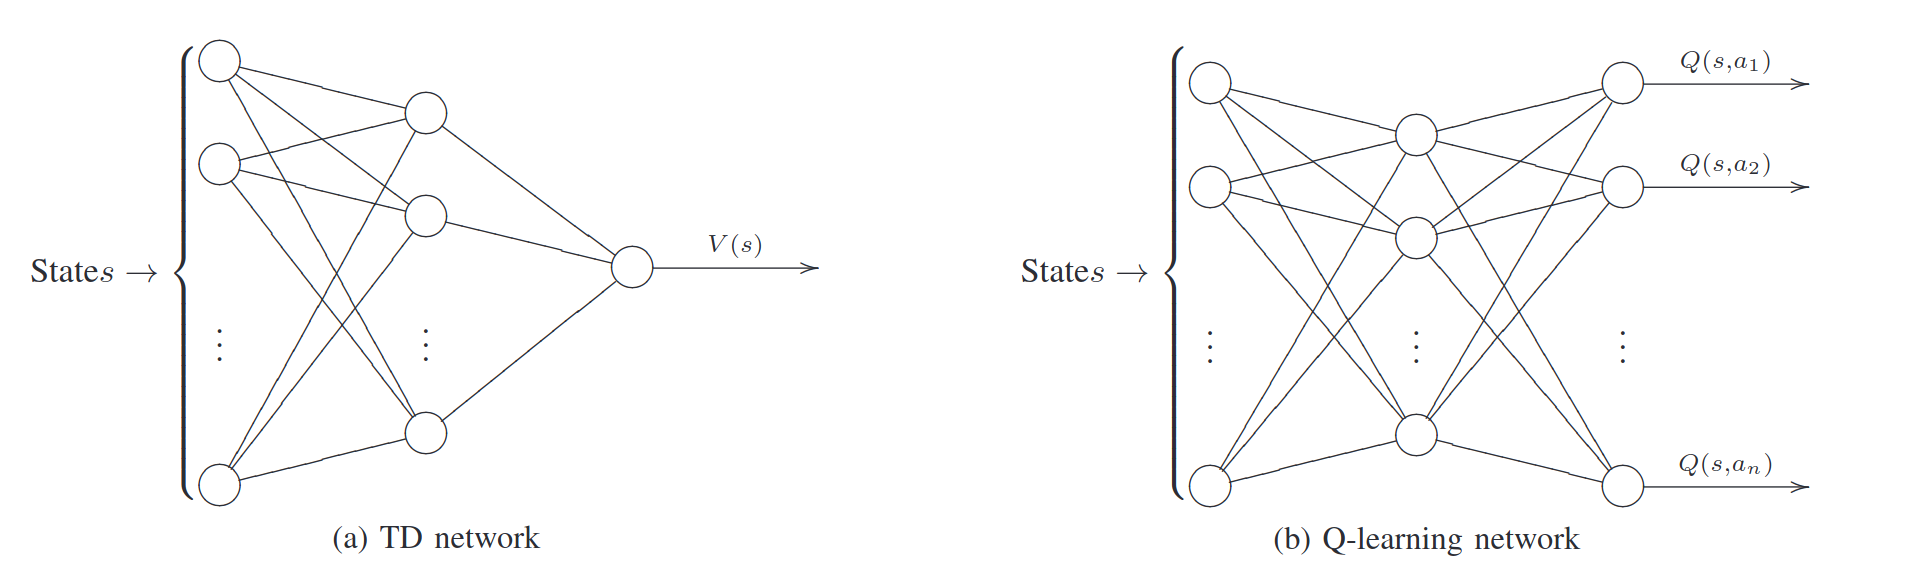
Diferentes topologias para o Othello. Repr. de (van der Ree e Wiering 2013)

* Há uma diversidade muito grande de redes a se considerar. As redes propostas em (van der Ree e Wiering 2013) têm muitos parâmetros e são demoradas para treinar, mas considere por exemplo uma rede *convolucional* para o Q Learning que tenta determinar o valor de uma jogada em uma posição considerando apenas as 8 posições vizinhas. São apenas 9 parâmetros!

* Vale a pena aprender *durante* a competição? Note que é passado um identificador para o jogador oponente, e você tem 2 segundos e meio para processar a notificação de término. Por outro lado, são apenas 200 partidas...

* A sua AI vai selecionar a melhor jogada de acordo com algum critério. Em seguida, a AI adversária vai fazer o mesmo.
Supondo que *ambas* as AIs sejam razoavelmente competentes, é razoável supor que elas estimem valores similares para as mesmas posições.
Isso significa que você pode *estimar* o comportamento do seu adversário "colocando-se no lugar dele". Considere então escolher a ação que *minimiza* a *melhor ação possível* do seu adversário.
Note que é possível ir ainda mais longe nesta busca, mas considere os limites de tempo!

* É melhor adotar uma política *determinística* ou *estocástica*?



